In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from differentiable_lensing import DifferentiableLensing
import differentiable_lensing
import data

In [2]:
device = 'cpu'

Initialising the DifferentiableLensing module to a lower resolution for the purposes of demonstration

In [3]:
shape = 64
lensing_module = DifferentiableLensing('cpu', target_resolution=0.101, target_shape=shape, alpha=None)
theta_e = 3
theta_x, theta_y, theta_x_as, theta_y_as = lensing_module.make_center_grid(-0.101 * shape / 2.0, 0.101 * shape / 2.0, shape)
theta_x_as, theta_y_as = theta_x_as.unsqueeze(0), theta_y_as.unsqueeze(0)
alpha = lensing_module.construct_sis(theta_x_as, theta_y_as, theta_e)
beta_x, beta_y = lensing_module.backward_lensing(theta_x_as, theta_y_as, alpha)

Initialising the deflection field

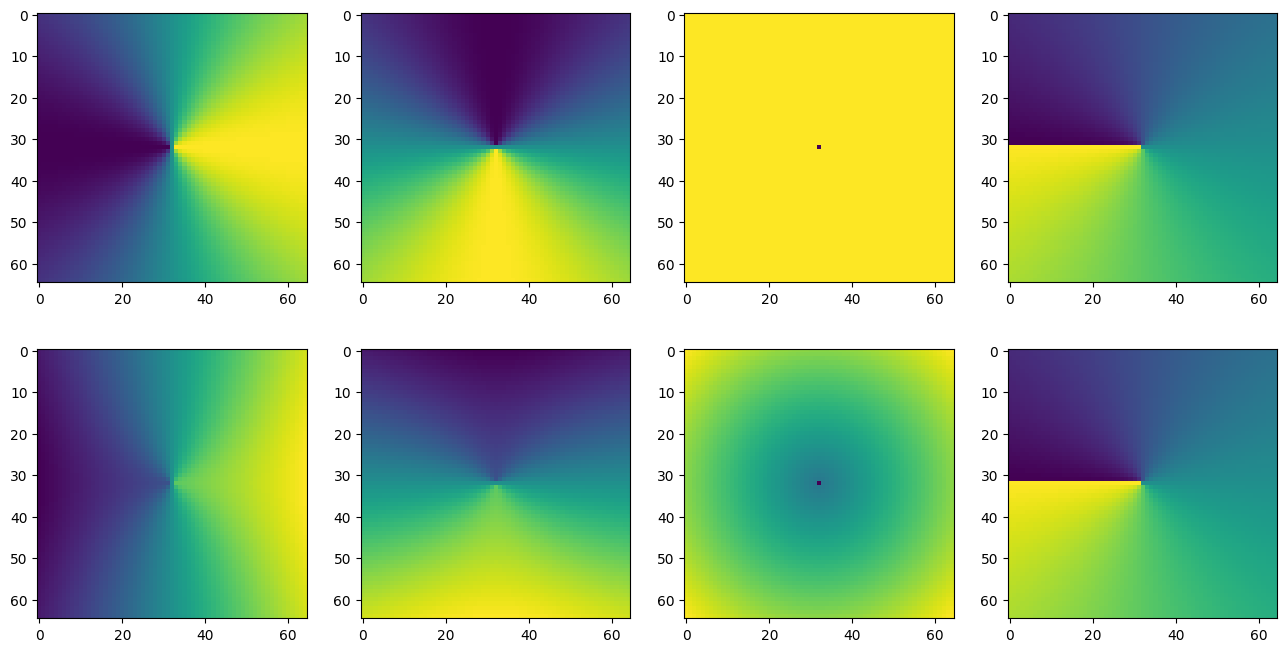

In [4]:
plot, axes = plt.subplots(2, 4)
plot.set_size_inches(16,8)
alpha_x, alpha_y = alpha[0], alpha[1]
alpha_r, alpha_t = (alpha_x**2 + alpha_y**2).sqrt(), torch.arctan2(alpha_y, alpha_x)
beta_r, beta_t = (beta_x**2 + beta_y**2).sqrt(), torch.arctan2(beta_y, beta_x)
axes[0][0].imshow(alpha_x)
axes[0][1].imshow(alpha_y)
axes[0][2].imshow(alpha_r)
axes[0][3].imshow(alpha_t)
axes[1][0].imshow(beta_x[0])
axes[1][1].imshow(beta_y[0])
axes[1][2].imshow(beta_r[0])
axes[1][3].imshow(beta_t[0])

In [5]:
cg_to_log = torch.load('scatter_to_log_%d.pt'%shape)
cg_forward_from_log = torch.load('forward_from_log_%d.pt'%shape)
cg_from_log = torch.load('scatter_from_log_%d.pt'%shape)
cg_backward = torch.load('sparse_grid_fracs_euclid_backward.pt')

Loading datasets

In [6]:
dataset_no_sub = data.LensingDataset('train/',['no_sub'],5000)
dataset_axion = data.LensingDataset('train/',['axion'],5000)
dataset_cdm = data.LensingDataset('train/',['cdm'],5000)

train_dataset = torch.utils.data.ConcatDataset([dataset_no_sub, dataset_axion, dataset_cdm])

In [7]:
target_shape = shape
y = np.arange(0, target_shape, 1)
x = np.arange(0, target_shape, 1)
xx, yy = np.meshgrid(x, y)

cx, cy = (target_shape - 1) / 2, (target_shape - 1) / 2
std = 2
g = np.exp(-(((xx - cx) ** 2 + (yy - cy) ** 2) / (2 * std ** 2)))

test_source = torch.tensor(g, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
log_source = lensing_module.cross_grid_fill(test_source, [cg_to_log])
log_image = lensing_module.cross_grid_fill(log_source, [cg_forward_from_log])
image = lensing_module.cross_grid_fill(log_image, [cg_from_log])

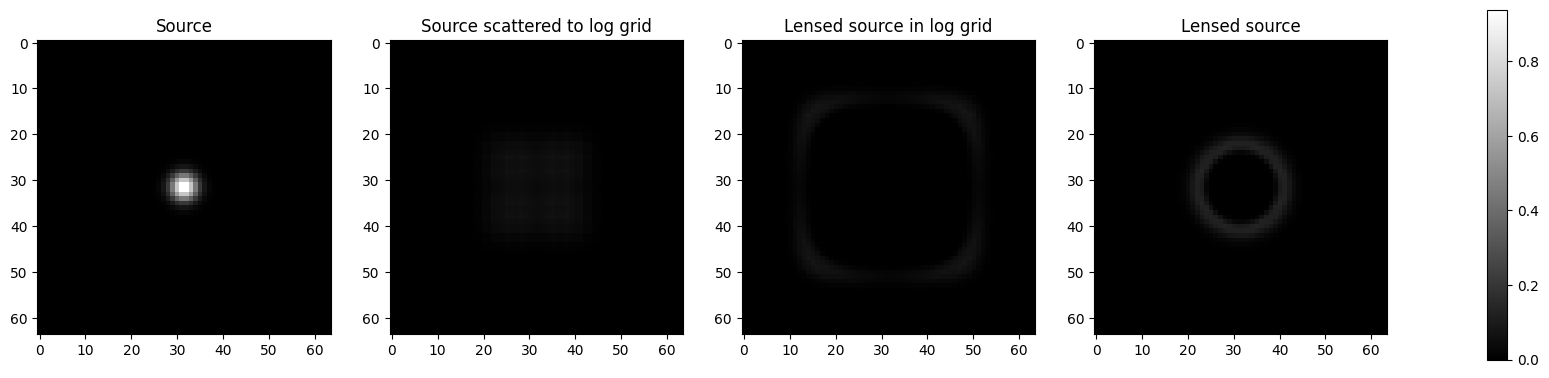

In [8]:
plot, axes = differentiable_lensing.shared_colorimshow([test_source[0,0], log_source[0,0], log_image[0,0], image[0,0]], 
                                1, 
                                4,
                                cmap='grey',
                                set_title=['Source', 'Source scattered to log grid', 'Lensed source in log grid', 'Lensed source'])

Plotting lensed images for reference

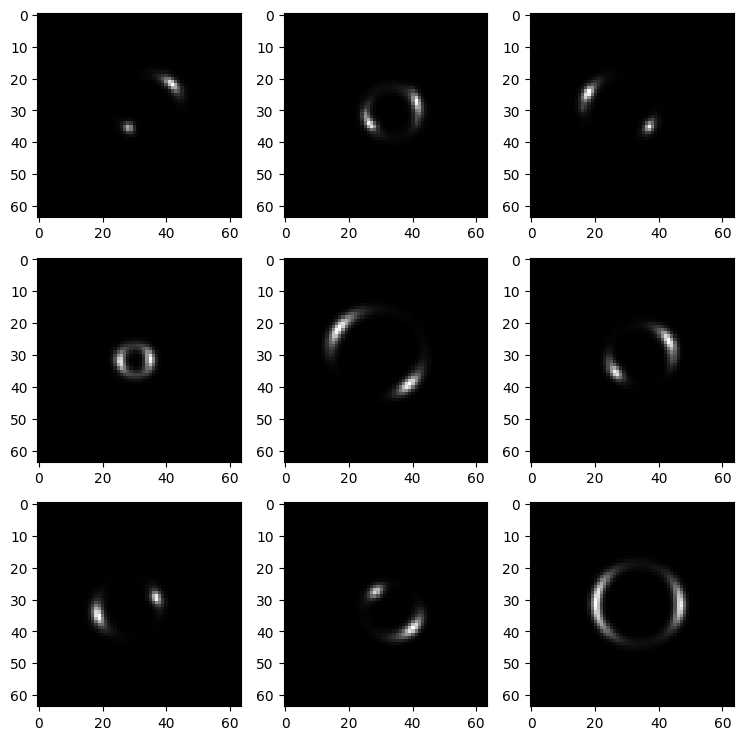

In [9]:
plot, axes = plt.subplots(3, 3)
plot.set_size_inches(9,9)
for i in range(3):
    for j in range(3):
        axes[i][j].imshow(train_dataset[i+5000*j].numpy()[0,0], cmap='grey')

In [10]:
demo_images = []
for i in range(3):
    for j in range(3):
        demo_images.append((train_dataset[i+5000*j].float())*255)
demo_images = torch.cat(demo_images, dim=0)

Plotting the reconstructed sources

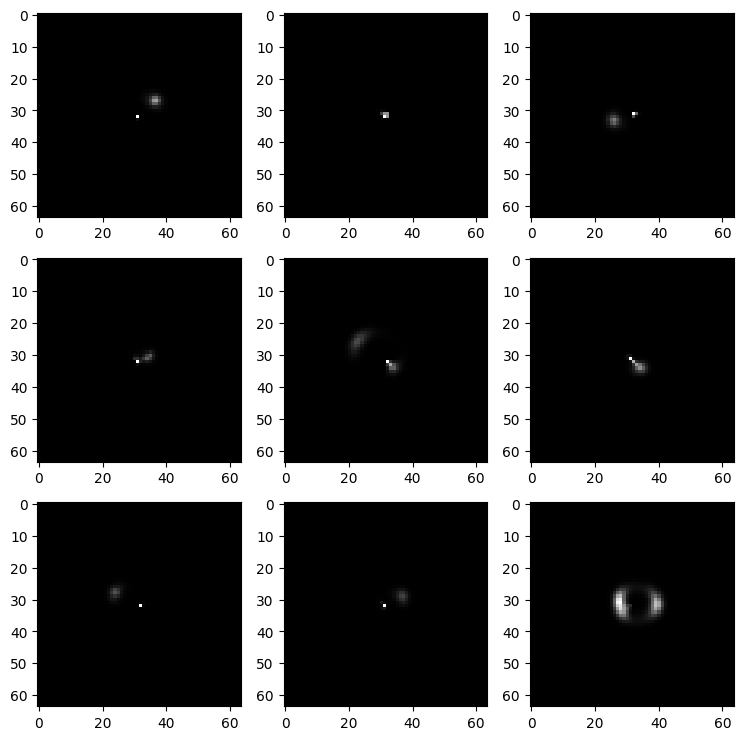

In [11]:
reconstructed_sources = lensing_module.cross_grid_fill(demo_images, [cg_backward])
plot, axes = plt.subplots(3, 3)
plot.set_size_inches(9,9)
for i in range(3):
    for j in range(3):
        axes[i][j].imshow((reconstructed_sources[i+3*j]).numpy()[0], cmap='grey')

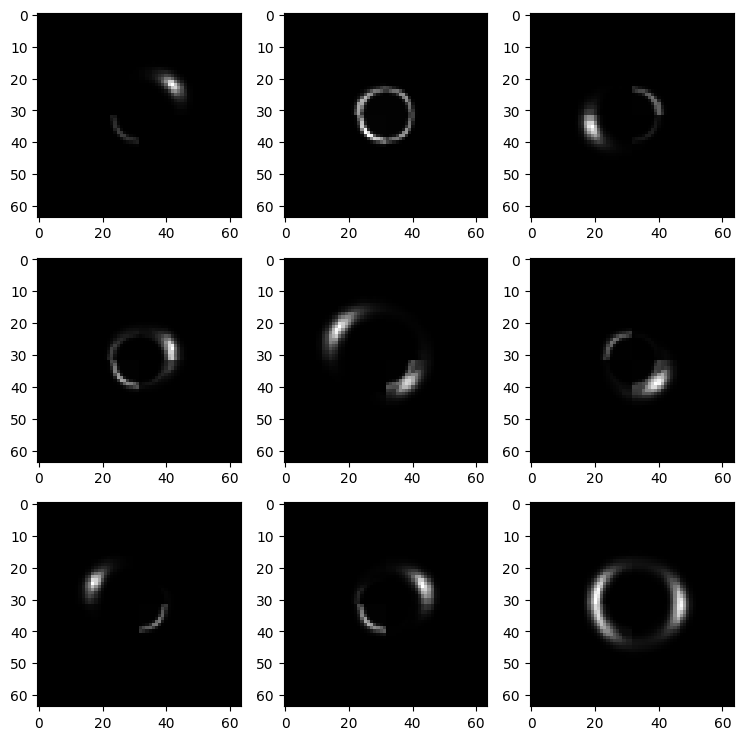

In [13]:
relensed_images = lensing_module.cross_grid_fill(reconstructed_sources, [cg_to_log, cg_forward_from_log, cg_from_log])
plot, axes = plt.subplots(3, 3)
plot.set_size_inches(9,9)
for i in range(3):
    for j in range(3):
        axes[i][j].imshow((relensed_images[i+3*j]).numpy()[0], cmap='grey')

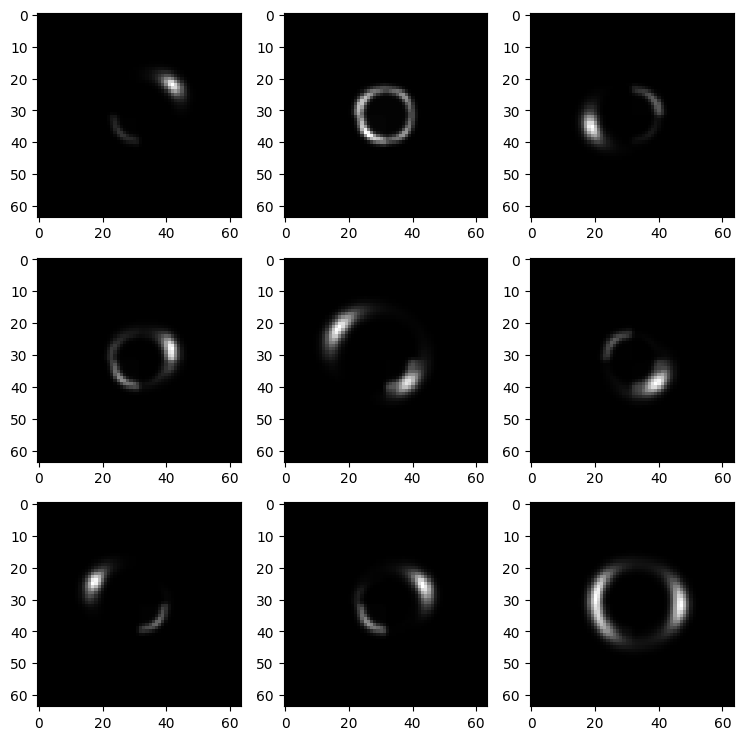

In [14]:
psf, _, _ = lensing_module.gaussian_kernel(fwhm_arcsec=0.16, pixscale_arcsec=0.101)
psf = torch.tensor(psf, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
convolved_upscaled_image = torch.nn.functional.conv2d(relensed_images, psf, padding="same")
plot, axes = plt.subplots(3, 3)
plot.set_size_inches(9,9)
for i in range(3):
    for j in range(3):
        axes[i][j].imshow((convolved_upscaled_image[i+3*j]).numpy()[0], cmap='grey')